In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
# read data
df = pd.read_csv('/kaggle/input/foodwaste/food-waste-pilot (1).csv')

In [3]:
df.head()

,date_collection_datetime,lbs_collected,compost_created_lbs
0,2/25/2022,250.8,25
1,3/2/2022,298.8,30
2,3/21/2022,601.2,60
3,3/28/2022,857.2,86
4,3/30/2022,610.8,61


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   date_collection_datetime  177 non-null    object 
 1   lbs_collected             177 non-null    float64
 2   compost_created_lbs       177 non-null    int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 4.3+ KB


In [5]:
df=df.rename(columns={'date_collection_datetime':'date'})

In [6]:
#convert date data to datetime datatype 
df['date']=pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df=df.sort_index()

In [7]:
#Display number missing values per column
df.isna().sum()

lbs_collected          0
compost_created_lbs    0
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 177 entries, 2022-02-09 to 2023-03-31
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   lbs_collected        177 non-null    float64
 1   compost_created_lbs  177 non-null    int64  
dtypes: float64(1), int64(1)
memory usage: 4.1 KB


In [9]:
df.describe()

,lbs_collected,compost_created_lbs
count,177.000000,177.000000
mean,540.366102,53.960452
std,194.943913,19.491654
min,0.000000,0.000000
25%,411.800000,41.000000
50%,537.600000,54.000000
75%,670.600000,67.000000
max,1065.800000,107.000000


## Visualizing

array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>],
      dtype=object)

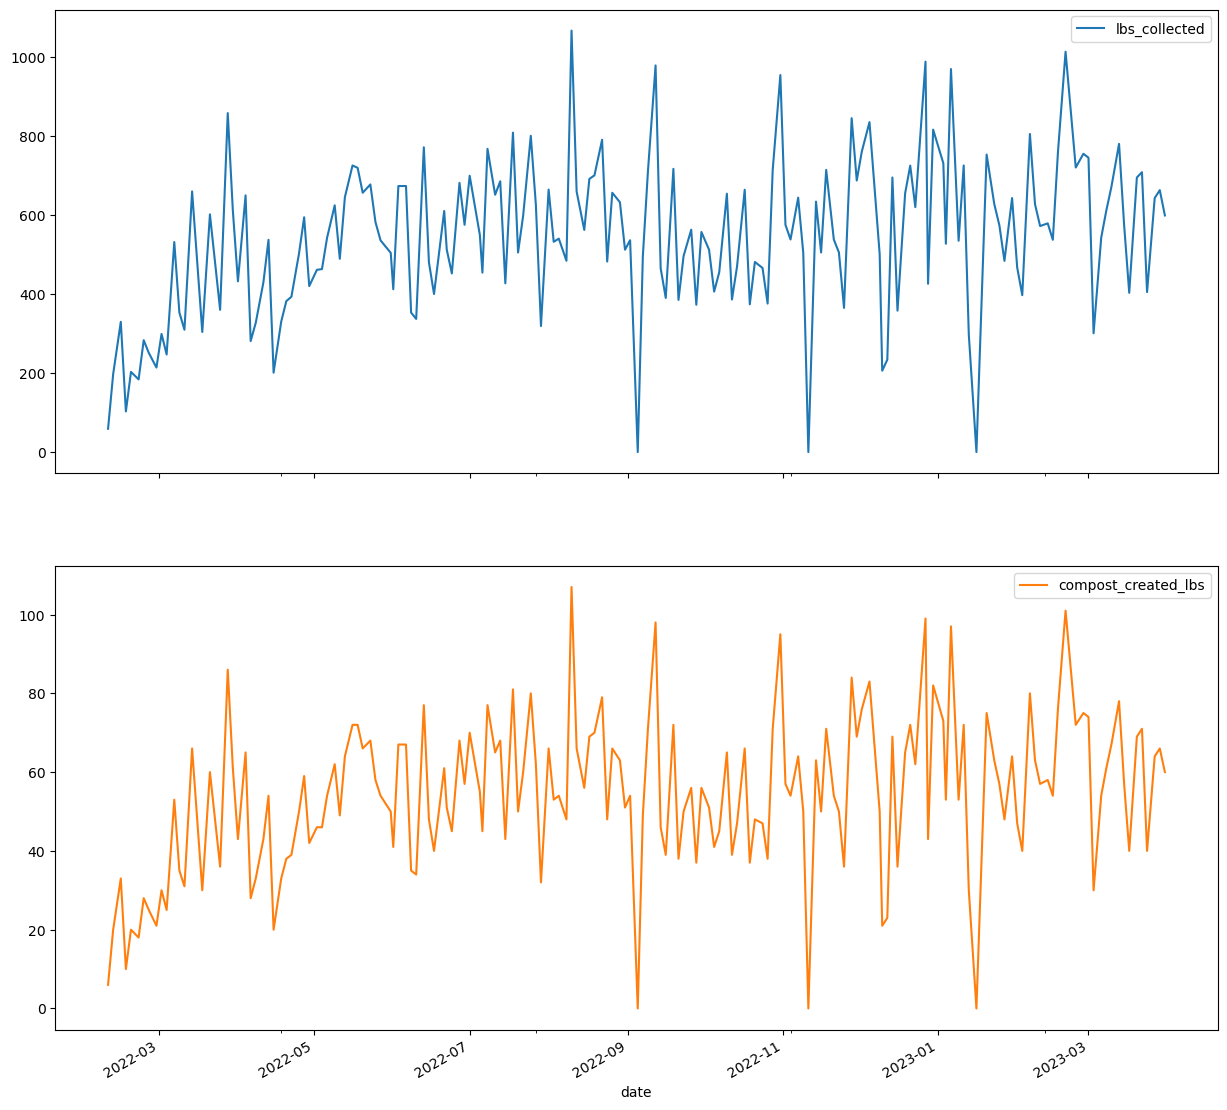

In [10]:
df.plot(kind='line', figsize=(15,15), subplots=True)

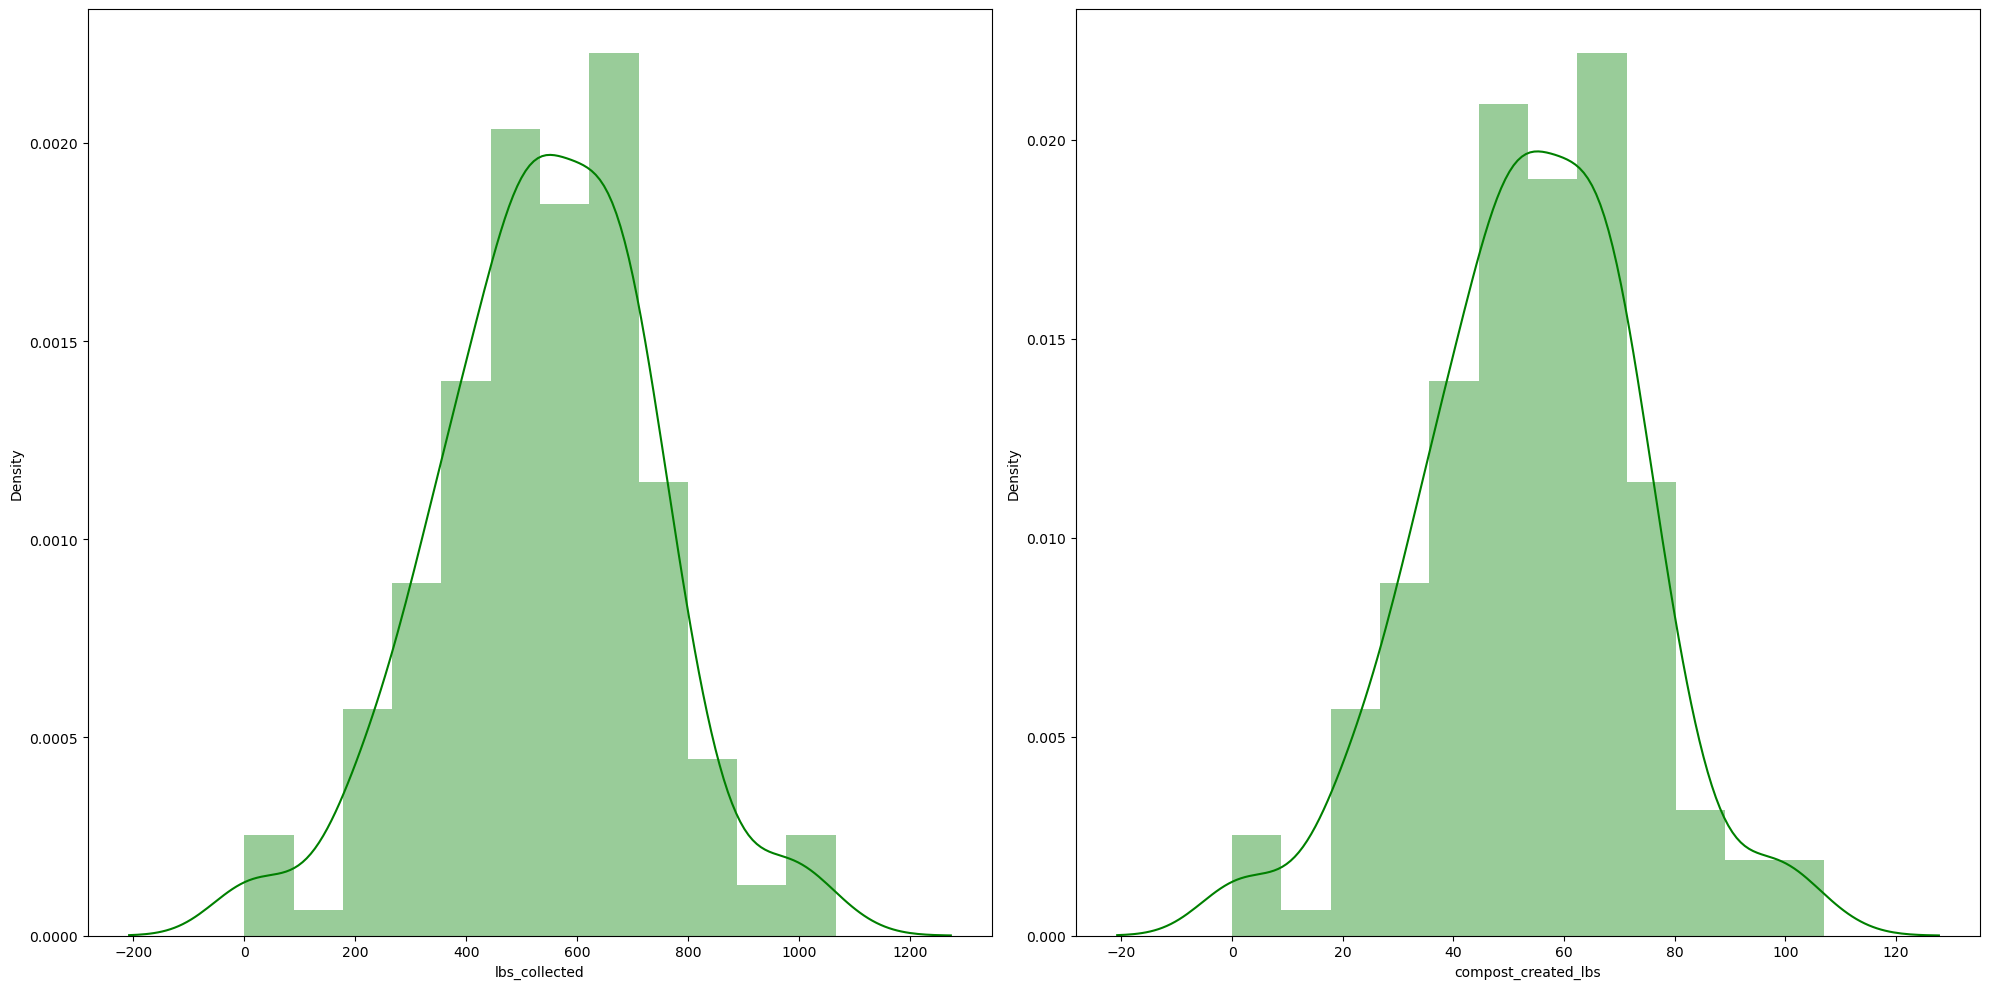

In [11]:
plt.subplots(figsize=(20,10))
 
for i, col in enumerate(df.columns):
  plt.subplot(1,2,i+1)
  sns.distplot(df[col],color='green')
plt.tight_layout()
plt.show()

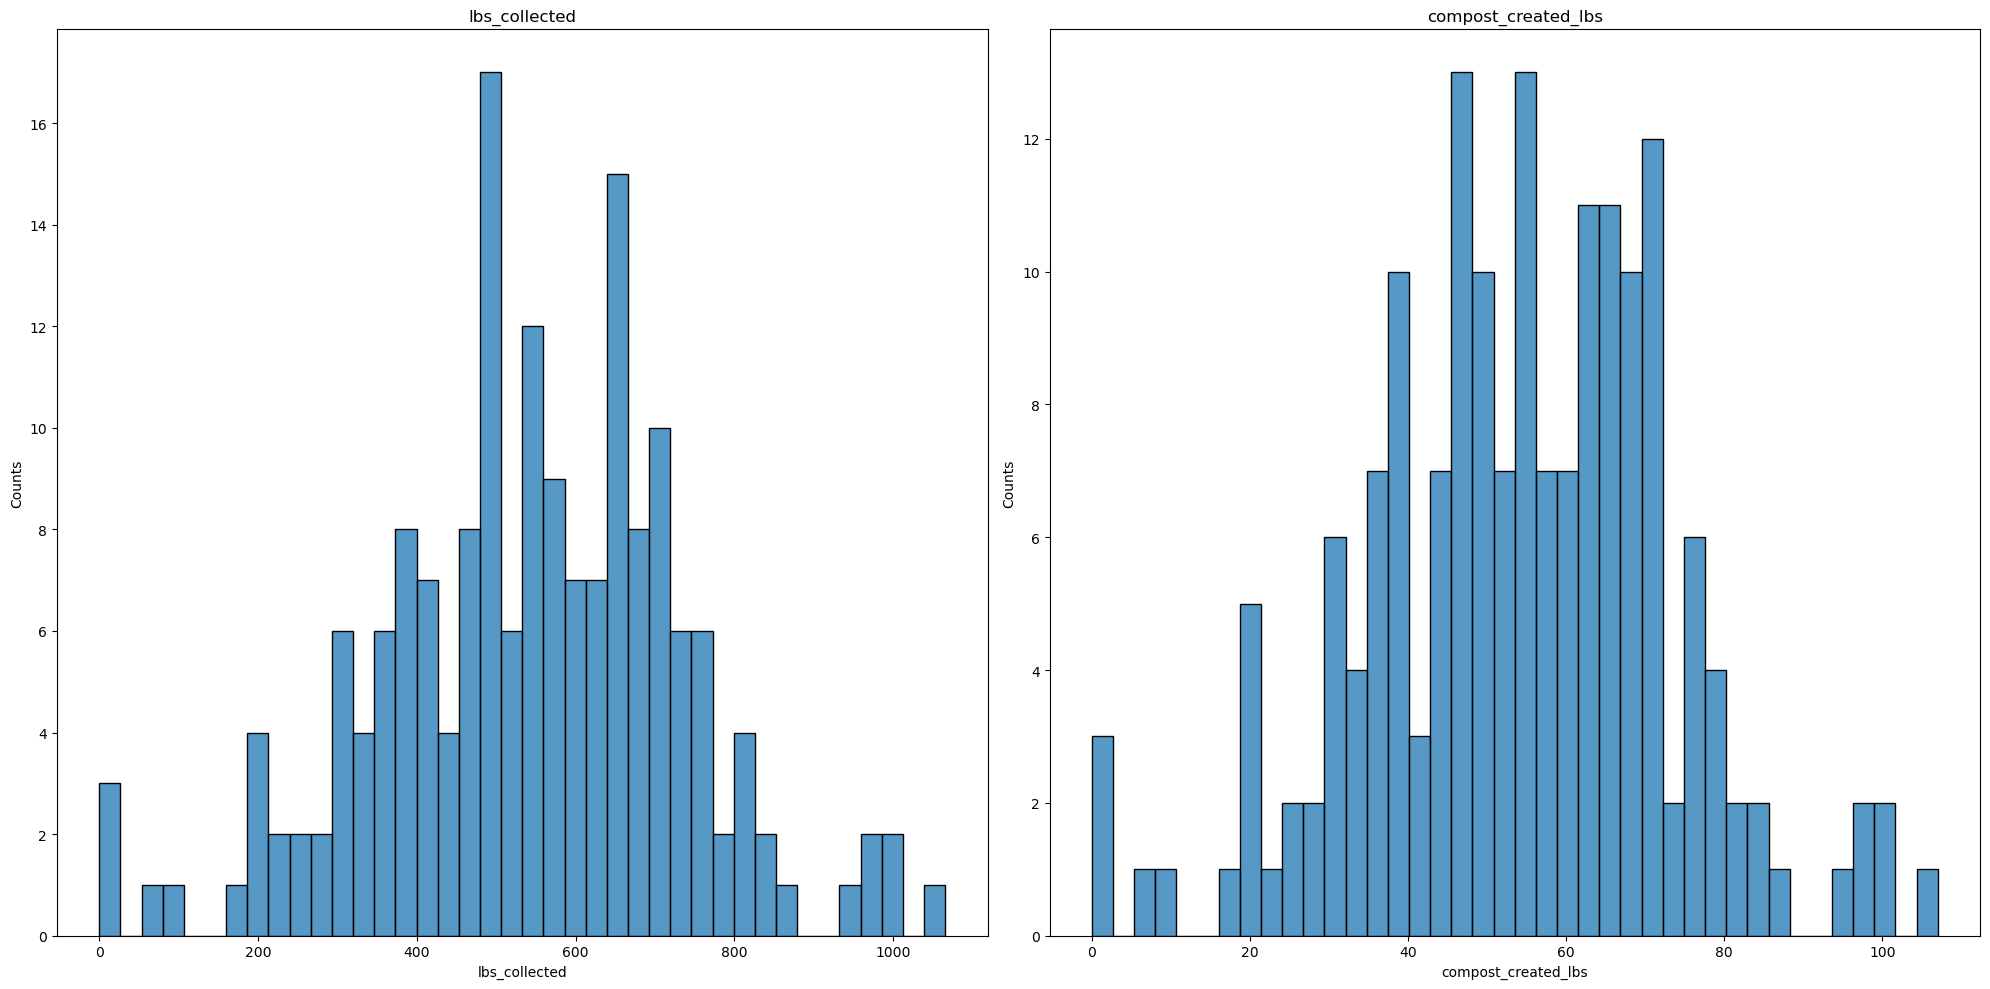

In [12]:
plt.subplots(figsize=(20,10))
 
for i, col in enumerate(df.columns):
  plt.subplot(1,2,i+1)
  sns.histplot(data=df, x=df[col], bins=40).set(title=col,ylabel="Counts")
plt.tight_layout()
plt.show()

## Data Preprocessing

Dickey-fuller Test for checking stationarity. 

Null hypothesis: the time series is non- stationary. If Test statistics less than critical value, then reject the null hypothesis and conclude that the dataset is stationary. Also if p-value << alpha (0.05) then reject null and conclude data is stationary


In [13]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling( window=3,center=False).mean()
    rolstd = timeseries.rolling(window=3,center=False).std()
#Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print( 'Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value.round(2)
    print (dfoutput)
    


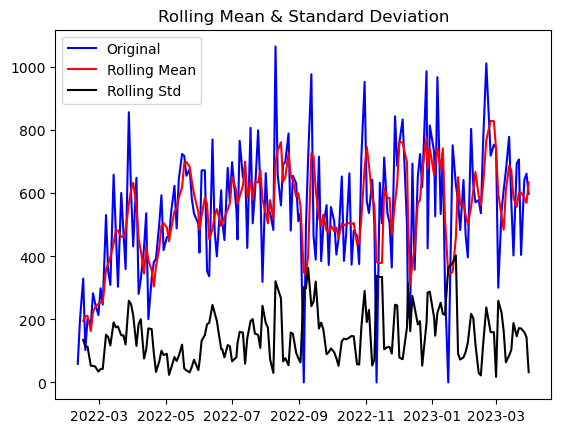

Results of Dickey-Fuller Test:
Test Statistic                -1.047206e+01
p-value                        1.276730e-18
#Lags Used                     0.000000e+00
Number of Observations Used    1.760000e+02
Critical Value (1%)           -3.470000e+00
Critical Value (5%)           -2.880000e+00
Critical Value (10%)          -2.580000e+00
dtype: float64


In [14]:
test_stationarity(df['lbs_collected'])

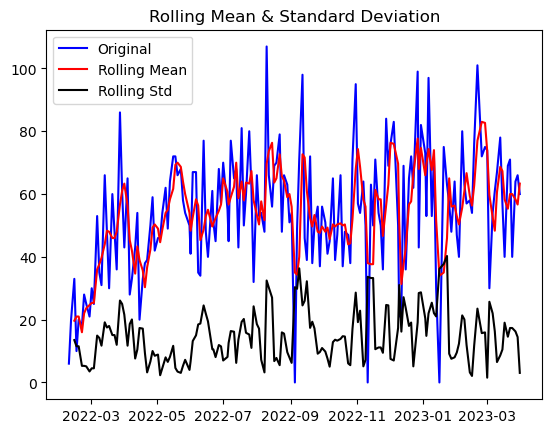

Results of Dickey-Fuller Test:
Test Statistic                -1.045998e+01
p-value                        1.367082e-18
#Lags Used                     0.000000e+00
Number of Observations Used    1.760000e+02
Critical Value (1%)           -3.470000e+00
Critical Value (5%)           -2.880000e+00
Critical Value (10%)          -2.580000e+00
dtype: float64


In [15]:
test_stationarity(df['compost_created_lbs'])


- Yes, from the data for lbs_collected is stationary.

- For lbs_collected, test statistic= -10.47206 < critical value. SO reject the null hypothesis and conclude that the time series is stationary.

- Additionally, the p-value (1.276730e-18) is smaller than 0.05, which further supports the rejection of the null hypothesis and the conclusion that the data is stationary.

## Model

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


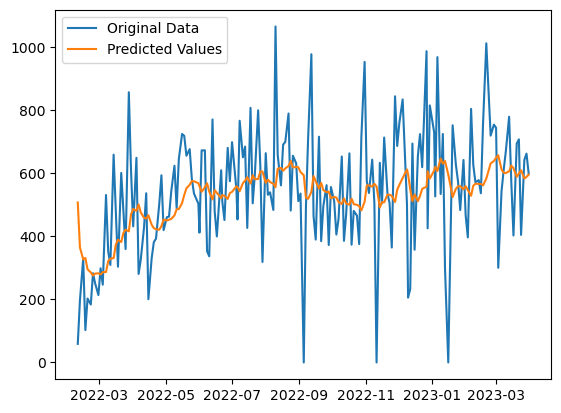

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# fit the ARIMA model
model = ARIMA(df['lbs_collected'], order=(1, 0, 1)) # specify the order of the model
results = model.fit()

# make predictions with the model
predictions = results.predict()

# plot the original data and the predicted values
plt.plot( df['lbs_collected'], label='Original Data')
plt.plot(predictions.index, predictions, label='Predicted Values')
plt.legend()
plt.show()


First, I will check if the series is stationary using the Augmented Dickey Fuller test (ADF Test), from the statsmodels package. The reason being is that we need differencing only if the series is non-stationary. Else, no differencing is needed, that is, d=0.


The null hypothesis (Ho) of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then we reject the null hypothesis and infer that the time series is indeed stationary.


So, in our case, if P Value > 0.05 we go ahead with finding the order of differencing.

In [17]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df['lbs_collected'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -10.472063
p-value: 0.000000


p< 0.005 so reject null and infer stationary

In [18]:
from statsmodels.tsa.arima.model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(df['lbs_collected'], order=(0,0,0))
model_fit = model.fit()
print(model_fit.summary())

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:          lbs_collected   No. Observations:                  177
Model:                          ARIMA   Log Likelihood               -1183.921
Date:                Sun, 16 Apr 2023   AIC                           2371.841
Time:                        09:11:05   BIC                           2378.194
Sample:                             0   HQIC                          2374.418
                                - 177                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        540.3663     14.729     36.687      0.000     511.498     569.235
sigma2      3.777e+04   3713.227     10.171      0.000    3.05e+04     4.5e+04
Ljung-Box (L1) (Q):                  10.74   Jarque-

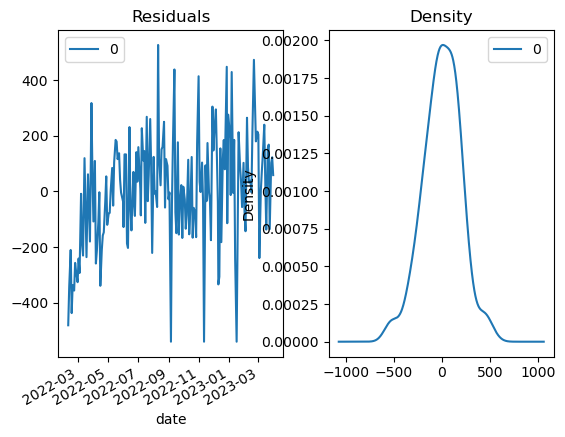

In [19]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

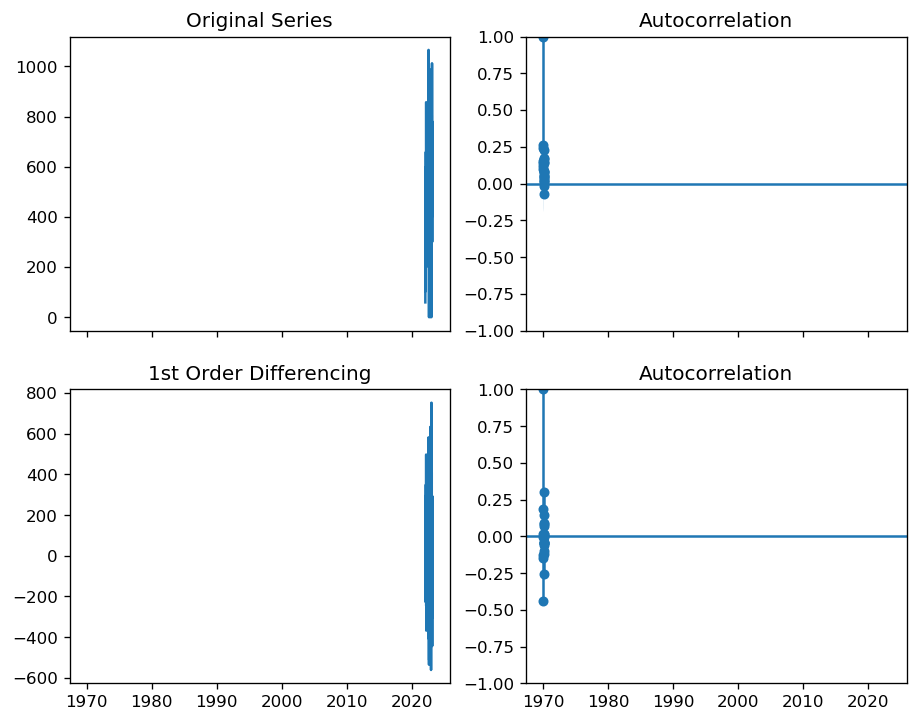

In [20]:
# Importing the modules
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# fixing the size
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(2, 2, sharex=True)
axes[0, 0].plot(df['lbs_collected']); axes[0, 0].set_title('Original Series')
plot_acf(df['lbs_collected'], ax=axes[0, 1])
# 1st Differencing to make stationary time series data
axes[1, 0].plot(df['lbs_collected'].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df['lbs_collected'].diff().dropna(), ax=axes[1, 1])
plt.show()
plt.show()

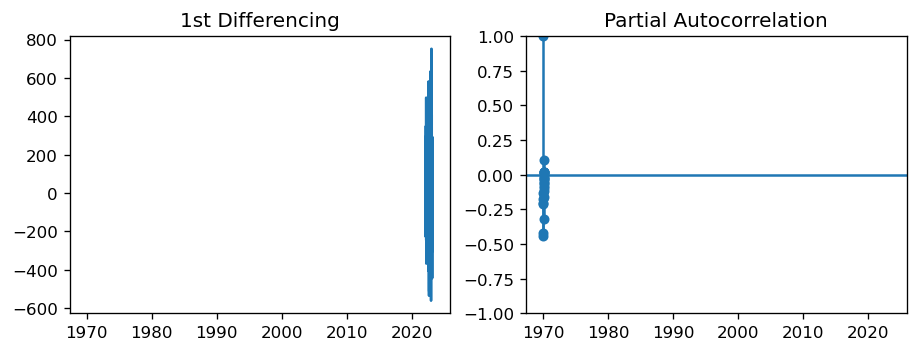

In [21]:
#importing modules
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
# fixing the axis
fig, axes = plt.subplots(1, 2, sharex=True)
# plotting on differen axis
axes[0].plot(df['lbs_collected'].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
# plotting partial autocorrelation function
plot_pacf(df['lbs_collected'].diff().dropna(), ax=axes[1])
plt.show()

In [22]:
# Create Training and Test

from sklearn.model_selection import train_test_split

# using the train test split function
X_train, X_test,y_train, y_test = train_test_split(df.index, df['lbs_collected'] ,
                                   random_state=104, 
                                   test_size=0.25, 
                                   shuffle=False)
split=int(0.8 * len(df))

train = df[:split]
test=df[split:]

In [23]:
import statsmodels.tsa.arima.model.ARIMA

# Convert the dataframe to a time series
ts = pd.Series(df['lbs_collected'])

# Split the data into training and testing sets
train_size = int(len(ts) * 0.8)
train, test = ts[0:train_size], ts[train_size:len(ts)]

# Create an ARIMA model
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()

# Use the ARIMA model to make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

# Plot the predictions and the actual values
plt.plot(test.values)
plt.plot(predictions, color='red')
plt.show()




ModuleNotFoundError: No module named 'statsmodels.tsa.arima.model.ARIMA'; 'statsmodels.tsa.arima.model' is not a package

In [ ]:
len(newdates)

In [ ]:
newdates